In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from statistics import mode
import tensorflow as tf
import random
import os
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import shuffle

In [169]:
# Read the CSV file to classify whether the student has a A score 
df_matA = pd.read_csv('mat_A.csv', sep=',')
data = df_matA.to_numpy()[:, 1:]

# standarize the data 
indices_to_standarize = []
for i, feature in enumerate(data[0]):
    if type(feature) != str and i != (data.shape[1]-1):
        indices_to_standarize.append(i)

for i in indices_to_standarize:
    m = np.mean(data[:, i])
    std = np.std(data[:, i])
    data[:, i] = (data[:, i]-m)/std

all_data = data.copy()

# Assuming all_data is your original dataset
np.random.seed(42)  # For reproducibility
np.random.shuffle(all_data)

# Calculate the size of the validation set (1/5th of the total data)
validation_size = len(all_data) // 10

# Split the data
validation_set = all_data[:validation_size] # the validating set 
data = all_data[validation_size:] # the testing set 

# split in to training and testing
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.1, random_state=0)

In [170]:
def dist(x1, x2):
    total_dist = 0
    
    for i, feature in enumerate(x1):
        # for numerical values, the distance is manhattan
        if type(feature) != str:
            total_dist += abs(x1[i] - x2[i])
        # for categorical values, the distance is hamming
        else:
            if x1[i] != x2[i]:
                total_dist += 1
    return total_dist

In [171]:
def find_min(dists, k):
    x_sorted = np.sort(dists)
    min_values = x_sorted[:k]
    indices = [dists.index(value) for value in min_values]
    return indices
    

In [172]:
# knn
def knn(X_train, X_test, y_train, y_test, k):
    # split in to training and testing
    # X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.1, random_state=0)
    y_pred = []

    # for each test data
    for x in X_test:
        
        # get an array represent the distance between x and each training data
        distances = []
        for x_train in X_train:
            distances.append(dist(x, x_train))
        
        # find the k lowest distance
        lowest_indices = find_min(distances, k)
        
        # majority vote from these k
        pred = mode(y_train[lowest_indices])
        
        # append the predicted result to the prediction array
        y_pred.append(pred)
        
    accuracy = sum(y_pred == y_test)/len(y_pred)
    return accuracy

In [173]:
def knn_cv(data, k, n_folds=5):
    random.seed(42)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.1, random_state=0)
    
    # Shuffle the data
    X, y = shuffle(X_train, y_train)

    # Split the dataset into n_folds parts
    fold_size = len(X) // n_folds
    accuracies = []

    for i in range(n_folds):
        # Create test and training sets for this fold
        start, end = i * fold_size, (i + 1) * fold_size
        X_test, y_test = X[start:end], y[start:end]
        X_train = np.concatenate((X[:start], X[end:]))
        y_train = np.concatenate((y[:start], y[end:]))

        # Calculate accuracy for this fold using the knn function
        accuracy = knn(X_train, X_test, y_train, y_test, k)
        accuracies.append(accuracy)
    
    # Average accuracy across folds
    mean_accuracy = np.mean(accuracies)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    folds = range(1, 6)  # Folds: 1, 2, 3, 4, 5
    plt.bar(folds, accuracies, color='lightblue', edgecolor='black')
    plt.axhline(y=mean_accuracy, color='r', linestyle='-', linewidth=2)
    plt.text(5.5, mean_accuracy, f'Mean: {mean_accuracy:.2f}', color = 'red', va='center')

    plt.title('Cross-Validation Accuracy Scores per Fold for KNN')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(folds)
    plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
    plt.grid(True, axis='y')
    plt.show()

    return mean_accuracy

In [174]:
# ANN
def ann(data, unit_num1, act_func1, unit_num2, act_func2, unit_num3, act_func3):
    random_seed = 0
    os.environ['PYTHONHASHSEED']=str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)

    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Initialize the ANN model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=unit_num1, activation=act_func1))
    model.add(tf.keras.layers.Dense(units=unit_num2, activation=act_func2))
    model.add(tf.keras.layers.Dense(units=unit_num3, activation=act_func3))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

In [175]:
def ann_cv(data, unit_num1, act_func1, unit_num2, act_func2, unit_num3, act_func3, folds=5):
    # Initialize KFold
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)

    accuracies = []

    # Iterate over each fold
    for train_index, test_index in kf.split(data):
        # Split the data
        train_data, test_data = data[train_index], data[test_index]

        # Call your ann function
        accuracy = ann(train_data, unit_num1, act_func1, unit_num2, act_func2, unit_num3, act_func3)
        accuracies.append(accuracy)

    # Calculate the average accuracy across all folds
    mean_accuracy = np.mean(accuracies)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    folds = range(1, 6)  # Folds: 1, 2, 3, 4, 5
    plt.bar(folds, accuracies, color='lightblue', edgecolor='black')
    plt.axhline(y=mean_accuracy, color='r', linestyle='-', linewidth=2)
    plt.text(5.5, mean_accuracy, f'Mean: {mean_accuracy:.2f}', color = 'red', va='center')

    plt.title('Cross-Validation Accuracy Scores per Fold for ANN')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(folds)
    plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
    plt.grid(True, axis='y')
    plt.show()
    return mean_accuracy

In [176]:
def decision_tree(data, crit, split, max_dep, min_samp_split):
    # decision tree
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)

    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)
    y_train = y_train.tolist()
    y_test = y_test.tolist()

    # Creating a decision tree classifier
    clf = DecisionTreeClassifier(criterion=crit, splitter=split, max_depth=max_dep, min_samples_split=min_samp_split, random_state=0)

    # Fitting the classifier to the training data
    clf.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = clf.predict(X_test)  # clf is your trained decision tree classifier

    # Evaluating the classifier
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [177]:
def decision_tree_cv(data, crit, split, max_dep, min_samp_split):
    # Initialize KFold
    kf = KFold(n_splits=5, random_state=0, shuffle=True)

    accuracies = []

    for train_index, test_index in kf.split(data):
        # Splitting the data into training and test sets for each fold
        train_data = data[train_index]
        test_data = data[test_index]

        # Here you would call your original decision_tree function
        accuracy = decision_tree(train_data, crit, split, max_dep, min_samp_split)
        accuracies.append(accuracy)

    # Calculating average accuracy across all folds
    mean_accuracy = sum(accuracies) / len(accuracies)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    folds = range(1, 6)  # Folds: 1, 2, 3, 4, 5
    plt.bar(folds, accuracies, color='lightblue', edgecolor='black')
    plt.axhline(y=mean_accuracy, color='r', linestyle='-', linewidth=2)
    plt.text(5.5, mean_accuracy, f'Mean: {mean_accuracy:.2f}', color = 'red', va='center')

    plt.title('Cross-Validation Accuracy Scores per Fold for Decision Tree')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(folds)
    plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
    plt.grid(True, axis='y')
    plt.show()
    return mean_accuracy



In [178]:
def random_forest(data, n_estimators, criterion, max_depth, min_samples_split):
    # decision tree
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)
    
    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)
    y_train = y_train.tolist()
    y_test = y_test.tolist()
    
    rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42) 
    rf_model.fit(X_train, y_train)
    
    predictions = rf_model.predict(X_test)
    
    return accuracy_score(y_test, predictions)




In [179]:
# cross validation random forest

def random_forest_cv(data, n_estimators, criterion, max_depth, min_samples_split):
    # Process data
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)
    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    data = new_data

    # Define the model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, 
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split, 
                                      random_state=42)

    # Split data into features and target
    X = data[:, :-1]
    y = data[:, -1]
    y = y.tolist()

    # Define K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
    
    mean_accuracy = np.mean(cv_scores)
    # Plotting
    plt.figure(figsize=(10, 6))
    folds = range(1, 6)  # Folds: 1, 2, 3, 4, 5
    plt.bar(folds, cv_scores, color='lightblue', edgecolor='black')
    plt.axhline(y=mean_accuracy, color='r', linestyle='-', linewidth=2)
    plt.text(5.5, mean_accuracy, f'Mean: {mean_accuracy:.2f}', color = 'red', va='center')

    plt.title('Cross-Validation Accuracy Scores per Fold for Random Forest')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(folds)
    plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
    plt.grid(True, axis='y')
    plt.show()


    return np.mean(cv_scores)



In [180]:
# original model
print(knn(X_train, X_test, y_train, y_test, 5))
# print(ann(data, 64, 'relu', 32, 'relu', 1, 'sigmoid'))
# print(decision_tree(data, 'gini', 'best', 10, 3))
# print(random_forest(data, 100, "gini", 10, 2))

0.8888888888888888


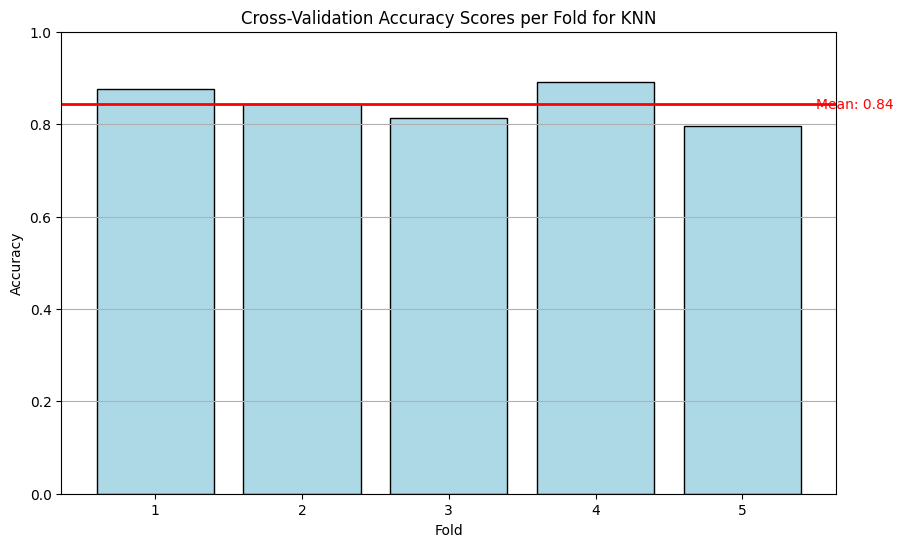

0.84375


In [181]:
# cross validation
print(knn_cv(data, 5))
# print(ann_cv(data, 64, 'relu', 32, 'relu', 1, 'sigmoid'))
# print(decision_tree_cv(data, 'gini', 'best', 10, 3))
# print(random_forest_cv(data, n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2))